In [1]:
import pandas as pd
import numpy as np
df = pd.read_excel("data/duplicates_labels.xlsx", index_col=0)

ModuleNotFoundError: No module named 'pandas'

In [2]:
df.reset_index(inplace=True, drop=True)

## Short cleaning

In [3]:
import pandas as pd
from fuzzywuzzy import fuzz
from sklearn.metrics import adjusted_mutual_info_score
import matplotlib.pyplot as plt
import re

# Clean tweet function
def clean_tweet(text):
    text = text.lower() 
    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions
    text = re.sub(r'#\w+', '', text)    # Remove hashtags

    # Remove non-alphabetic characters (except numbers)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Keep English and numbers

    # Remove extra whitespace
    text = ' '.join(text.split()).strip()

    return text

df['tweet_clean'] = df['tweet'].apply(clean_tweet)

Best Threshold: 84
Best Scores:
V-Measure: 0.9743
Adjusted Rand: 0.9843
Adjusted Mutual Info: 0.9668
Completeness: 0.9653
Homogeneity: 0.9835
Purity: 0.9891
Threshold: 84.0000


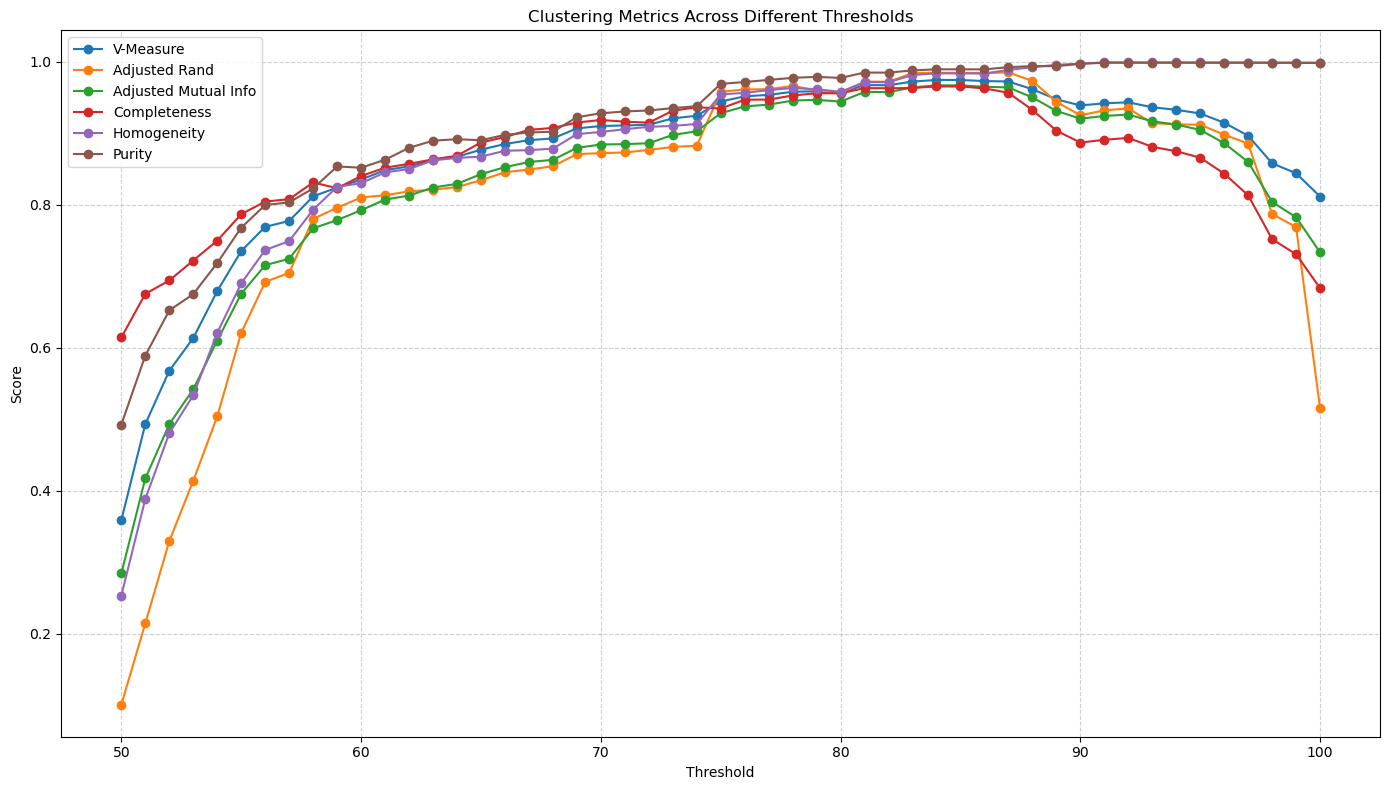

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    v_measure_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    completeness_score,
    homogeneity_score,
    precision_recall_fscore_support,
)
from rapidfuzz import fuzz
import matplotlib.pyplot as plt


def purity_score(y_true, y_pred):
    """Calculate the purity score."""
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)


def evaluate_metrics(df):
    """Evaluate clustering metrics on the true duplicate groups."""
    df['duplicate_group'] = df['duplicate_group'].fillna(-1).astype(int)
    true_groups = df['duplicate_group'].astype(int)
    pred_groups = df['fuzzy_group'].astype(int)

    scores = {
        'V-Measure': v_measure_score(true_groups, pred_groups),
        'Adjusted Rand': adjusted_rand_score(true_groups, pred_groups),
        'Adjusted Mutual Info': adjusted_mutual_info_score(true_groups, pred_groups),
        'Completeness': completeness_score(true_groups, pred_groups),
        'Homogeneity': homogeneity_score(true_groups, pred_groups),
        'Purity': purity_score(true_groups, pred_groups),
    }
    return scores


def create_fuzzy_groups_with_filter(df, threshold):
    """Group tweets based on fuzzy similarity in a single pass."""
    grouped = {}
    group_id = 0
    tweet_to_group = {}
    matched_indices = set()

    # Group and filter tweets simultaneously
    for idx, row in df.iterrows():
        tweet = row['tweet_clean']
        if idx in tweet_to_group:  # Skip if already grouped
            continue

        # Check similarity with existing groups
        added_to_group = False
        for group, tweets in grouped.items():
            if any(fuzz.ratio(tweet, t) >= threshold for t in tweets):
                grouped[group].append(tweet)
                tweet_to_group[idx] = group
                added_to_group = True
                break

        # Create a new group if not similar to existing ones
        if not added_to_group:
            grouped[group_id] = [tweet]
            tweet_to_group[idx] = group_id
            group_id += 1

        # Identify matches for the current tweet
        for other_idx, other_row in df.iterrows():
            if other_idx != idx and other_idx not in tweet_to_group:
                other_tweet = other_row['tweet_clean']
                if fuzz.ratio(tweet, other_tweet) >= threshold:
                    matched_indices.add(idx)
                    matched_indices.add(other_idx)
                    tweet_to_group[other_idx] = tweet_to_group[idx]
                    grouped[tweet_to_group[idx]].append(other_tweet)

    # Filter the dataset to keep only matched tweets
    matched_df = df.loc[list(matched_indices)].copy()
    matched_df['fuzzy_group'] = matched_df.index.map(tweet_to_group)

    return matched_df


def find_best_threshold_with_filter(df, thresholds):
    """Find the best threshold for clustering metrics with filtering of unmatched tweets."""
    best_results = []
    best_threshold = None
    best_scores = {}

    for threshold in thresholds:
        df_with_groups = create_fuzzy_groups_with_filter(df.copy(), threshold)
        scores = evaluate_metrics(df_with_groups)
        scores['Threshold'] = threshold
        best_results.append(scores)

        # Update best threshold based on V-Measure (or another preferred metric)
        if not best_threshold or scores['V-Measure'] > best_scores.get('V-Measure', 0):
            best_threshold = threshold
            best_scores = scores

    return pd.DataFrame(best_results), best_threshold, best_scores

def plot_metric_results(results_df):
    """Plot clustering metrics for different thresholds."""
    thresholds = results_df['Threshold']
    metrics = ['V-Measure', 'Adjusted Rand', 'Adjusted Mutual Info', 'Completeness', 'Homogeneity', 'Purity']

    plt.figure(figsize=(14, 8))
    for metric in metrics:
        plt.plot(thresholds, results_df[metric], marker='o', label=metric)

    plt.title("Clustering Metrics Across Different Thresholds")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Define thresholds to test (e.g., 50 to 100)
thresholds_to_test = range(50, 101, 1)

# Find the best threshold
results_df, best_threshold, best_scores = find_best_threshold_with_filter(df, thresholds_to_test)

# Print best threshold and metrics
print(f"Best Threshold: {best_threshold}")
print("Best Scores:")
for metric, score in best_scores.items():
    print(f"{metric}: {score:.4f}")

# Plot the results
plot_metric_results(results_df)


In [ ]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
from multiprocessing import Pool
import re
from sklearn.metrics import (
    v_measure_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    completeness_score,
    homogeneity_score,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt

def clean_tweet(text):
    """
    Cleans a tweet by removing URLs, mentions, hashtags, special characters, and extra spaces.
    """
    text = text.lower() 
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions
    text = re.sub(r'#\w+', '', text)    # Remove hashtags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Keep only English letters and numbers
    return ' '.join(text.split()).strip()  # Remove extra whitespace

def find_groups_single_threshold_in_chunk(args):
    """
    Compares a chunk of tweets to the entire dataset to find duplicates and group them by similarity.
    Unmatched tweets will be labeled with -1.
    """
    chunk, tweets, threshold, length_margin = args
    group_ids = []
    seen_groups = {}  # Dictionary to track existing groups by tweet
    
    for idx, tweet in enumerate(chunk):
        assigned_group = -1  # Start by assigning -1 (unmatched)
        
        for j, other_tweet in enumerate(tweets):
            # Check tweet length similarity
            if abs(len(tweet) - len(other_tweet)) > length_margin:
                continue
            
            # Compute similarity
            similarity = fuzz.ratio(tweet, other_tweet)
            if similarity >= threshold:
                # If a match is found, assign the same group as the matched tweet
                assigned_group = seen_groups.get(j, j)  # Use existing group or create a new one
                break
        
        # Record the group assignment for this tweet (either -1 or the assigned group)
        seen_groups[len(seen_groups)] = assigned_group
        group_ids.append(assigned_group)
    
    return group_ids


def apply_group_detection_single_threshold_parallel(df, threshold=84, length_margin=30):
    """
    Parallelized duplicate detection with grouping using a single threshold.
    """
    # Pre-sort by tweet length to reduce unnecessary comparisons
    df = df.sort_values(by="tweet_clean", key=lambda x: x.str.len()).reset_index(drop=True)
    tweets = df["tweet_clean"].tolist()

    # Split tweets into chunks for parallel processing
    num_chunks = 16  # Adjust based on the number of CPU cores
    chunks = np.array_split(tweets, num_chunks)
    
    # Prepare arguments for multiprocessing
    args = [(chunk, tweets, threshold, length_margin) for chunk in chunks]
    
    # Use multiprocessing to compare chunks
    with Pool(num_chunks) as pool:
        results = pool.map(find_groups_single_threshold_in_chunk, args)

    # Combine results
    results_flat = [item for sublist in results for item in sublist]
    df["fuzzy_group"] = results_flat  # Assign the group ids to the dataframe
    
    # Handle groups that only have one occurrence
    group_counts = df["fuzzy_group"].value_counts()
    single_occurrence_groups = group_counts[group_counts == 1].index.tolist()
    
    # Change group IDs with only one occurrence to -1
    df["fuzzy_group"] = df["fuzzy_group"].apply(lambda x: -1 if x in single_occurrence_groups else x)
    
    return df


# Clean the tweets
df['tweet_clean'] = df['tweet'].apply(clean_tweet)

# Apply the duplicate detection and grouping process
threshold = 84  # Adjust the threshold to 84
length_margin = 30  # Allowable margin for tweet length similarity
df_with_groups = apply_group_detection_single_threshold_parallel(df, threshold, length_margin)

print("Duplicate detection and grouping completed.")


Duplicate detection and grouping completed. Results saved to 'rapidfuzz_processed_groups_sample_fuzzy_group.csv'.


In [7]:
len(df_with_groups)

1000

In [12]:
len(df_with_groups.fuzzy_group.unique())

76

In [8]:
import numpy as np
import pandas as pd
from rapidfuzz import fuzz
from sklearn.metrics import classification_report, precision_recall_fscore_support

def evaluate_duplicate_detection_single_threshold(df):
    """
    Evaluates duplicate detection based on a single threshold.
    Labels non-duplicates as -1.
    """

    # True labels
    true_labels = df['duplicate_group'].notna().astype(int)  # Duplicates as 1, non-duplicates as 0
    pred_labels = (df['fuzzy_group'] != -1).astype(int)  # Convert -1 to 0 (non-duplicates), 1 otherwise

    # Evaluate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average="binary"
    )
    report = classification_report(true_labels, pred_labels, target_names=["Non-Duplicate", "Duplicate"])
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "classification_report": report,
        "df": df
    }


# Run evaluation
results = evaluate_duplicate_detection_single_threshold(df_with_groups)

# Print metrics
print(f"Threshold: {threshold}")
print(f"Precision: {results['precision']:.2f}")
print(f"Recall: {results['recall']:.2f}")
print(f"F1-Score: {results['f1']:.2f}")
print("\nClassification Report:")
print(results['classification_report'])

Threshold: 84
Precision: 0.97
Recall: 0.94
F1-Score: 0.95

Classification Report:
               precision    recall  f1-score   support

Non-Duplicate       0.89      0.94      0.91       341
    Duplicate       0.97      0.94      0.95       659

     accuracy                           0.94      1000
    macro avg       0.93      0.94      0.93      1000
 weighted avg       0.94      0.94      0.94      1000

